# LSTM Stock Price Prediction

This project uses an LSTM neural network to forecast stock prices using historical data. The goal is to predict future closing prices based on past trends.

We will:
- Collect historical price data
- Preprocess the data
- Build and train an LSTM model
- Visualize the predicted vs actual prices
- Forecast the next day's closing price

## Importing Relevant Frameworks

In this section, we import the core libraries needed for the project:

- yfinance: Easily downloads historical stock market data
- sklearn: Used for data scaling (via MinMaxScaler) to prepare for LSTM input
- tensorflow.keras: A high-level deep learning API used to build and train our LSTM model

We also include standard libraries like numpy, pandas, and matplotlib for data processing and visualization.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## Setting Up Our Parameters

In this section, we define our target stock and timeframe for prediction.

- **Ticker:** PDD refers to Pinduoduo Inc., a major Chinese e-commerce platform that became hugely popular during my time working in China. Its explosive growth and high volatility make it a compelling candidate for time-series modeling.

- **Date Range:** We're using data from **2012 to 2025** to simulate a realistic long-term modeling scenario that captures various market conditions — from the pre-pandemic economy, through COVID-19 disruptions, to the more recent recovery and growth phases.

We also **normalize the stock prices** between 0 and 1 using MinMaxScaler from sklearn. This standardization helps prevent large values from skewing the model and ensures consistent performance by reducing numerical instability. It also speeds up the training process and improves convergence in LSTM networks.


In [9]:
company = 'PDD'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2025, 1, 1)

data = yf.download(company, start, end)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


[*********************100%***********************]  1 of 1 completed


## Setting Up the Training Sequences

To train our model, we convert raw price data into sequences the LSTM can learn from:

- **Sequence Length:** We use the previous **60 days** of prices to predict the next day's closing price. This length is common in finance — it captures short- and mid-term market memory, balancing sensitivity and noise.

- **Input/Target Pairing:**
  - x_train consists of 60-day rolling windows of price data.
  - y_train contains the next-day price following each 60-day window.

- **Reshaping for LSTM:** LSTMs require 3D input:
  - **Samples**: Number of sequences.
  - **Time steps**: Length of each sequence (60).
  - **Features**: Number of variables per time step (1, for closing price).

This setup transforms our price history into a structured dataset optimized for temporal pattern recognition.


In [10]:
prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Building the LSTM Model

Now that our training data is ready, we build a deep Long Short-Term Memory (LSTM) network using TensorFlow/Keras. LSTMs are ideal for time-series data like stock prices because they retain memory over long sequences and learn complex temporal dependencies.

### Model Architecture Breakdown

- **Sequential()**: We use a Sequential model because this is a straightforward stack of layers — ideal for our single-input, single-output time series task.

#### LSTM Layers (x3)

We use **three LSTM layers**, each with 50 memory units:

- **Why 3 Layers?** More layers allow the model to capture deeper, more abstract temporal patterns. Early layers can detect short-term trends, while later layers learn higher-level seasonality or momentum.

- **units=50**: Each LSTM layer uses 50 neurons — a practical starting point that balances learning capacity and overfitting risk.

- **return_sequences=True** (for first 2 LSTMs): This ensures that each LSTM layer returns the full sequence to the next layer, not just the final output.

#### Dropout Layers (x3)

Each LSTM layer is followed by a **Dropout** layer (rate=0.2):

- Dropout randomly disables 20% of the neurons during training, which helps prevent **overfitting** — especially critical when working with limited financial data.

#### Output Layer

- A single **Dense layer** with units=1 provides our prediction — the next day's closing price. This is a **regression task**, so there's no activation function here.

### Compilation and Training

- **optimizer='adam'**: Adam is a widely used optimizer for its fast convergence and adaptive learning rate properties.
- **loss='mean_squared_error**: MSE is the standard loss function for continuous value prediction.
- **Training**: The model is trained for 100 epochs with a batch size of 32, meaning it updates its weights after processing 32 samples at a time.

This architecture is designed to balance complexity and generalizability while being suitable for deployment in practical forecasting pipelines.


In [11]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=32)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0527
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0057
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0042
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0042
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0039
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0049
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0035
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0036
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0035
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0029
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0030
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0033
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0027
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0028
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0026
E

## Model Evaluation and Plotting

In this section, we test our model on **unseen data** and visualize how well it performs.

### What We're Doing

- **Test Data Preparation**: We load stock data from **2020 to present** and align it with the training set to ensure proper input structure.
- **Scaling & Sequencing**: We apply the same MinMaxScaler used during training and create 60-day windows for each prediction point — just like in training.
- **Model Inference**: Using the trained LSTM, we predict the closing prices on this test dataset.
- **Inverse Transformation**: We convert scaled predictions back to actual price values for meaningful comparison.
- **Visualization**: We plot the **actual stock prices** against the **predicted prices**, allowing us to visually assess the model's performance over time.

This step provides a clear, intuitive check for how closely the model tracks real-world market behavior.


[*********************100%***********************]  1 of 1 completed


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


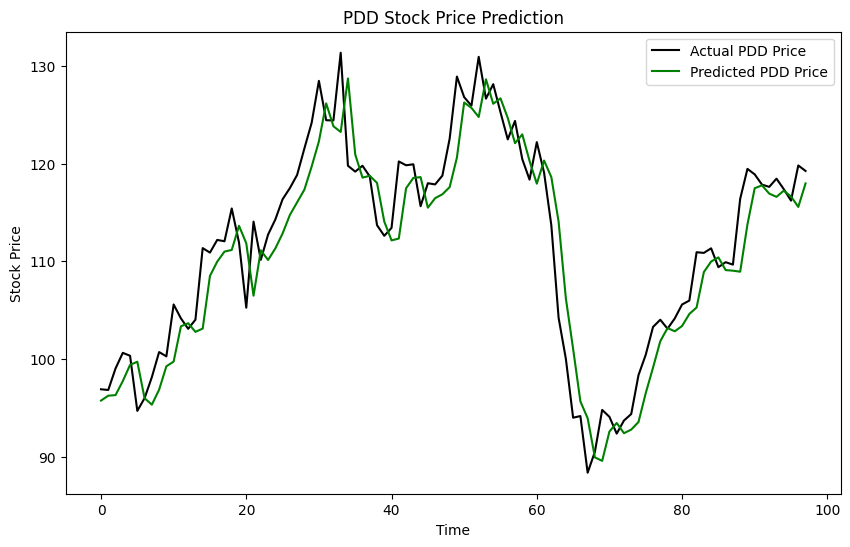

In [12]:
test_start = dt.datetime(2025, 1, 1)
test_end = dt.datetime.now()
test_data = yf.download(company, test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='black', label=f"Actual {company} Price")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} Price")
plt.title(f"{company} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Next-Day Forecast

As a final step, we use the last 60 days of available data to forecast the **next closing price**.

- We extract the most recent 60-day window from our test input.
- The trained LSTM model predicts the scaled closing price for the next day.
- We then convert that scaled output back into its original price using the inverse transformation.

This gives us a single-day prediction, offering a real-world use case for short-term forecasting in a live trading or monitoring environment.


In [13]:
real_data = [model_inputs[-prediction_days:]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Predicted next closing price: ${prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted next closing price: $118.21


## Results & Interpretation

The model demonstrates a strong ability to track the general trends and short-term fluctuations of PDD's stock price. With 100 training epochs, the predictions align closely with actual prices, suggesting reduced overfitting and improved generalization compared to earlier runs.

The final predicted next-day closing price is approximately **$118.21**, which aligns with recent observed prices, reinforcing the model's practical forecasting potential.


## Insights

- A 60-day lookback window provided a meaningful balance between short-term volatility and trend stability.
- The LSTM architecture was effective in capturing temporal dependencies in stock movements.
- Using MinMax scaling notably improved convergence speed and model stability.

## 🔮Future Considerations

To further enhance performance and robustness, the following future improvements are proposed:

- **Feature Expansion:** Include technical indicators (e.g., RSI, MACD) and trading volume for deeper context.
- **Model Architecture:** Explore transformer-based models or LSTM variants with attention mechanisms.
- **Hyperparameter Tuning:** Apply grid search or Bayesian optimization for optimal layer configuration.
- **Rolling Retraining:** Incorporate periodic updates with new market data to maintain relevance.
- **Uncertainty Estimation:** Introduce prediction intervals to quantify model confidence.